In [1]:
from openai import OpenAI
from pydantic import BaseModel
from typing import Dict, List,Tuple,Optional
from dotenv import load_dotenv
from utils import *
from chatty_boi import *
import os
from tqdm import tqdm
import pandas as pd
import pickle


In [2]:
with open("./prompt_lib/base_prompt.txt", "r") as f:
    prompt = f.read()

with open("./prompt_lib/constraint_prompt.txt", "r") as f:
    constraints_prompt = f.read()

with open("./prompt_lib/optimize_prompt.txt", "r") as f:
    optimize_prompt = f.read()

input_data = {}
with open("./prompt_lib/base_inputs.txt", "r") as f:
    exec(f.read(),{}, input_data)


base_prompt = prompt
constraints_prompt = constraints_prompt
optimize_prompt = optimize_prompt

node_dict_input = input_data["node_dict_input"]
example_members_input = input_data["example_members_input"]
area_id = input_data["area_id"]
load = input_data["load"]
supports = input_data["supports"]
area_id


{'0': 1,
 '1': 0.195,
 '2': 0.782,
 '3': 1.759,
 '4': 3.128,
 '5': 4.887,
 '6': 7.037,
 '7': 9.578,
 '8': 12.511,
 '9': 15.834,
 '10': 19.548}

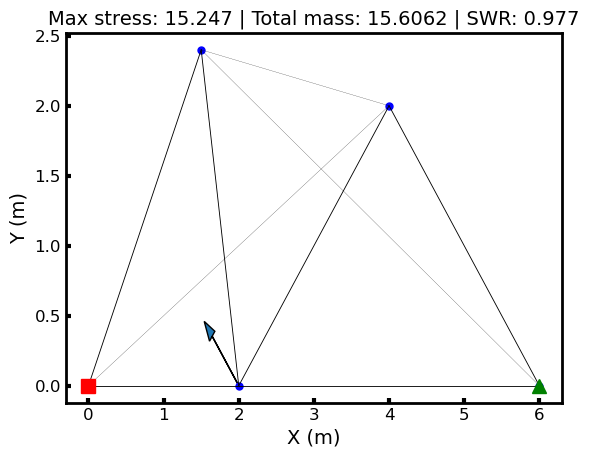

{'member_1': ['node_1', 'node_3', '2'],
 'member_2': ['node_3', 'node_2', '2'],
 'member_3': ['node_1', 'node_4', '2'],
 'member_4': ['node_2', 'node_5', '2'],
 'member_5': ['node_3', 'node_4', '2'],
 'member_6': ['node_3', 'node_5', '2'],
 'member_7': ['node_4', 'node_5', '1'],
 'member_8': ['node_4', 'node_2', '1'],
 'member_9': ['node_5', 'node_1', '1']}

In [3]:
df_q1 = pd.read_pickle("./results_final_runs/final_df_q1.pkl")

best_strcuture = df_q1["best_structure"][134]

plot_truss(best_strcuture)

node_dicts = df_q1["best_node"]
member_dicts = df_q1["best_member"][134]

member_dicts

Node‐count distribution:
num_nodes
4    100
5     67
6     11
7      1
8      1
Name: count, dtype: int64 

Member‐count distribution:
num_members
4      1
5     50
6     51
7     14
8     17
9     32
10     8
11     3
12     3
13     1
Name: count, dtype: int64 

Summary statistics:
        num_nodes  num_members
count  180.000000   180.000000
mean     4.533333     6.911111
std      0.688290     1.882851
min      4.000000     4.000000
25%      4.000000     5.000000
50%      4.000000     6.000000
75%      5.000000     9.000000
max      8.000000    13.000000 



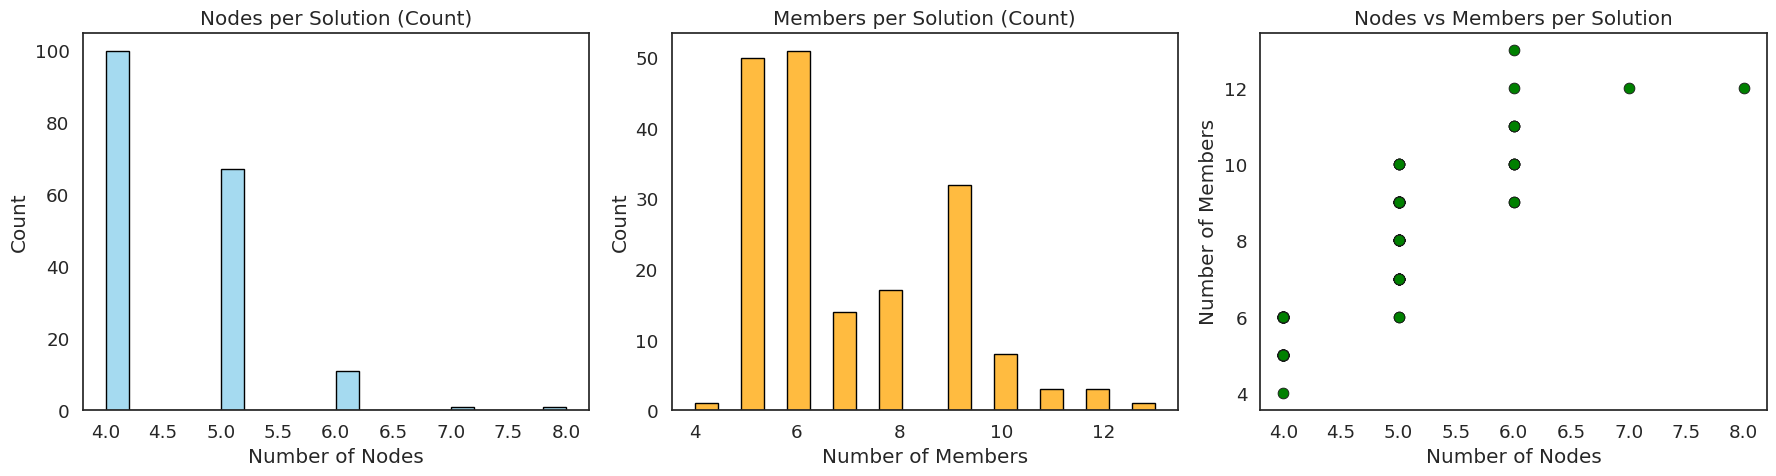

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Build DataFrame
counts = pd.DataFrame({
    'num_nodes':   df_q1['best_node'].apply(lambda d: len(d)),
    'num_members': df_q1['best_member'].apply(lambda d: len(d))
})

# Print distributions and summary
print("Node‐count distribution:")
print(counts['num_nodes'].value_counts().sort_index(), "\n")

print("Member‐count distribution:")
print(counts['num_members'].value_counts().sort_index(), "\n")

print("Summary statistics:")
print(counts.describe(), "\n")

# Set Seaborn style: NO grid
sns.set_theme(style="white", font_scale=1.2)

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Nodes count (Y-axis = count)
sns.histplot(
    counts['num_nodes'],
    bins=20,
    kde=False,
    stat='count',      # <-- CHANGE: stat = count
    ax=axes[0],
    color='skyblue',
    edgecolor='black',
)
axes[0].set_title('Nodes per Solution (Count)')
axes[0].set_xlabel('Number of Nodes')
axes[0].set_ylabel('Count')

# 2. Members count (Y-axis = count)
sns.histplot(
    counts['num_members'],
    bins=20,
    kde=False,
    stat='count',      # <-- CHANGE: stat = count
    ax=axes[1],
    color='orange',
    edgecolor='black'
)
axes[1].set_title('Members per Solution (Count)')
axes[1].set_xlabel('Number of Members')
axes[1].set_ylabel('Count')

# 3. Scatter Plot: Nodes vs Members
sns.scatterplot(
    data=counts,
    x='num_nodes',
    y='num_members',
    ax=axes[2],
    s=60,
    edgecolor='k',
    color='green'
)
axes[2].set_title('Nodes vs Members per Solution')
axes[2].set_xlabel('Number of Nodes')
axes[2].set_ylabel('Number of Members')


# Layout
plt.tight_layout()
plt.show()


In [5]:
positions = [
    coord
    for node_dict in df_q1['best_node']
    for coord in node_dict.values()
]
# unzip
xs, ys = zip(*positions)

print(f"X range: {min(xs):.3f} → {max(xs):.3f}")
print(f"Y range: {min(ys):.3f} → {max(ys):.3f}")

X range: 0.000 → 6.000
Y range: -2.000 → 4.400


In [6]:
node_dict_= df_q1["best_node"][134]
member_dict_ = df_q1["best_member"][134]

In [7]:
from itertools import combinations
import random

# node_dict = {name: (x, y) for name, x, y in best_strcuture.nodes}


def member_dict_to_vectors(member_dict, area_id_keys):
    """
    Splits member dict into connection vector and area vector.
    Node indices are auto-generated from unique nodes present in member_dict.
    """
    # Collect unique nodes used
    unique_nodes = sorted({node for m in member_dict.values() for node in m[:2]})
    node_key_to_idx = {key: idx for idx, key in enumerate(unique_nodes)}
    area_key_to_idx = {str(key): idx for idx, key in enumerate(area_id_keys)}
    
    sorted_keys = sorted(member_dict.keys())
    connection_vec = []
    area_vec = []
    for key in sorted_keys:
        start_node, end_node, area_id = member_dict[key]
        connection_vec.append(node_key_to_idx[start_node])
        connection_vec.append(node_key_to_idx[end_node])
        area_vec.append(area_key_to_idx[str(area_id)])
    return connection_vec, area_vec, sorted_keys, unique_nodes


def vectors_to_member_dict_independent(connection_vec, area_vec, node_dict, area_id_keys):
    """
    Reconstructs member dict from connection vector and area vector using node_dict.
    Node names are inferred from sorted(node_dict.keys()) by index.
    """
    assert len(connection_vec) % 2 == 0, "Connection vector must have even number of elements (start,end pairs)"
    assert len(connection_vec) // 2 == len(area_vec), "Mismatch between connections and areas"
    
    node_keys = sorted(node_dict.keys())
    num_members = len(area_vec)
    member_dict = {}
    
    member_keys = [f"member_{i+1}" for i in range(num_members)]
    
    for i in range(num_members):
        start_idx = connection_vec[2*i]
        end_idx = connection_vec[2*i + 1]
        area_idx = area_vec[i]
        
        start_node = node_keys[start_idx]
        end_node = node_keys[end_idx]
        area_id = area_id_keys[area_idx]
        
        member_dict[member_keys[i]] = (start_node, end_node, str(area_id))
    
    return member_dict


def node_dict_to_vector(node_dict):
    """Flattens a node dict to a 1D list in consistent order."""
    sorted_keys = sorted(node_dict.keys())
    vec = []
    for key in sorted_keys:
        vec.extend(node_dict[key])
    return vec, sorted_keys  # return order for decoding later

def vector_to_node_dict(vec):
    """Reconstructs a node dict from a 1D vector by generating keys automatically."""
    assert len(vec) % 2 == 0, "Vector length must be even (pairs of x,y)"
    num_nodes = len(vec) // 2
    node_dict = {}
    for i in range(num_nodes):
        key = f"node_{i+1}"  # auto-generate keys like node_1, node_2, etc.
        node_dict[key] = [vec[2*i], vec[2*i + 1]]
    return node_dict

def objective_func(x, member_dict, load, supports):
    new_dict = vector_to_node_dict(x)
    t = make_truss(new_dict, member_dict, load, supports)
    max_stress = max(np.abs(np.array(list(t.member_stress().values()))))
    w,_ = t.structure_mass()
    return np.array([max_stress, w])

def contraint_func_mass(x, member_dict, load, supports, max_weight=30):
    new_dict = vector_to_node_dict(x)
    t = make_truss(new_dict, member_dict, load, supports)
    # max_stress = max(np.abs(np.array(list(t.member_stress().values()))))
    curr_weight,_ = t.structure_mass()
    return max_weight-curr_weight

def contraint_func_stress(x, member_dict, load, supports, max_stress=30):
    new_dict = vector_to_node_dict(x, ss)
    t = make_truss(new_dict, member_dict, load, supports)
    curr_stress = max(np.abs(np.array(list(t.member_stress().values()))))
    return max_stress-curr_stress
    
constraints = [
    {'type': 'ineq', 'fun': contraint_func_mass},
    {'type': 'ineq', 'fun': contraint_func_stress},
]


n, ss = node_dict_to_vector(node_dict_)
out = vector_to_node_dict(n)

out

{'node_1': [0.0, 0.0],
 'node_2': [6.0, 0.0],
 'node_3': [2.0, 0.0],
 'node_4': [1.5, 2.4],
 'node_5': [4.0, 2.0]}

In [8]:
# connection_vec, area_vec, _, unique_nodes = member_dict_to_vectors(member_dict, area_id_keys=list(area_id.keys()))


In [9]:
def decode_connection_area_vec(x, n_nodes, n_areas):
    """
    Decodes a flat x vector into connection vector and area vector
    """
    n_members = len(x) // 3  # two for connection + one for area per member
    connection_vec = []
    area_vec = []
    for i in range(n_members):
        start_idx = int(np.clip(np.round(x[3*i + 0]), 0, n_nodes-1))
        end_idx = int(np.clip(np.round(x[3*i + 1]), 0, n_nodes-1))
        area_idx = int(np.clip(np.round(x[3*i + 2]), 0, n_areas-1))
        
        connection_vec.extend([start_idx, end_idx])
        area_vec.append(area_idx)
    
    return connection_vec, area_vec


In [10]:
from pymoo.core.problem import ElementwiseProblem

# class TrussConnectionOptimizationProblem(ElementwiseProblem):
#     def __init__(self, node_dict, load, supports, n_members, n_nodes, area_id_keys):
#         super().__init__(
#             n_var=n_members * 3,    # (start, end, area) per member
#             n_obj=2,                # max stress and mass
#             n_constr=2,             # mass and stress constraints
#             xl=0,
#             xu=n_nodes-1,           # node indices or area indices
#         )
#         self.node_dict = node_dict
#         self.load = load
#         self.supports = supports
#         self.area_id_keys = area_id_keys
#         self.n_nodes = n_nodes
#         self.n_members = n_members

#     def _evaluate(self, x, out, *args, **kwargs):
#         connection_vec, area_vec = decode_connection_area_vec(x, self.n_nodes, len(self.area_id_keys))
        
#         member_dict = vectors_to_member_dict_independent(connection_vec, area_vec, self.node_dict, self.area_id_keys)
#         try:
#             t = make_truss(self.node_dict, member_dict, self.load, self.supports)
#             stresses = np.abs(np.array(list(t.member_stress().values())))
#             mass, _ = t.structure_mass()
#             max_stress = np.max(stresses)
#         except Exception as e:
#             # If invalid truss, give huge penalties
#             max_stress = 1e6
#             mass = 1e6
        
#         out["F"] = np.array([max_stress, mass])
        
#         g1 = mass - 30   # mass constraint <= 30
#         g2 = max_stress - 15  # stress constraint <= 30
#         out["G"] = [g1, g2]


class TrussFullOptimizationProblem(ElementwiseProblem):
    def __init__(self, node_dict, load, supports, n_members, n_nodes, area_id_keys, fixed_nodes):
        """
        fixed_nodes: list of node names whose positions should stay fixed (e.g., load/support nodes)
        """
        self.node_dict = node_dict
        self.load = load
        self.supports = supports
        self.area_id_keys = area_id_keys
        self.n_nodes = n_nodes
        self.n_members = n_members
        
        self.fixed_nodes = fixed_nodes
        self.free_nodes = [k for k in sorted(node_dict.keys()) if k not in fixed_nodes]
        
        super().__init__(
            n_var=2*len(self.free_nodes) + 3*n_members,
            n_obj=2,
            n_constr=2,
            xl=np.concatenate([
                np.full(2*len(self.free_nodes), -10.0),  # position bounds
                np.zeros(3*n_members)                    # connections and area bounds
            ]),
            xu=np.concatenate([
                np.full(2*len(self.free_nodes), 10.0),   # position bounds
                np.concatenate([
                    np.full(2*n_members, n_nodes-1),    # connection indices bounds
                    np.full(n_members, len(area_id_keys)-1)  # area id bounds
                ])
            ])
        )

    def _evaluate(self, x, out, *args, **kwargs):
        # Decode x
        n_free = len(self.free_nodes)
        
        free_positions = x[:2*n_free]
        conn_area_vars = x[2*n_free:]
        
        connection_vec, area_vec = decode_connection_area_vec(conn_area_vars, self.n_nodes, len(self.area_id_keys))
        
        # Build new node dict
        new_node_dict = {}
        idx = 0
        for node in sorted(self.node_dict.keys()):
            if node in self.fixed_nodes:
                new_node_dict[node] = self.node_dict[node]
            else:
                new_node_dict[node] = [free_positions[idx], free_positions[idx+1]]
                idx += 2
        
        # Build member dict
        member_dict = vectors_to_member_dict_independent(connection_vec, area_vec, new_node_dict, self.area_id_keys)
        
        # Evaluate structure
        try:
            t = make_truss(new_node_dict, member_dict, self.load, self.supports)
            stresses = np.abs(np.array(list(t.member_stress().values())))
            mass, _ = t.structure_mass()
            max_stress = np.max(stresses)
        except Exception as e:
            # Infeasible structure
            max_stress = 1e6
            mass = 1e6
        
        out["F"] = np.array([max_stress, mass])
        
        g1 = mass - 30   # mass constraint <= 30
        g2 = max_stress - 15  # stress constraint <= 15
        out["G"] = [g1, g2]

In [11]:
import random

# First, group all node_dicts and member_dicts by (num_nodes, num_members)
temp_storage = {}

for idx, row in df_q1.iterrows():
    node_dict = row['best_node']
    member_dict = row['best_member']
    
    num_nodes = len(node_dict)
    num_members = len(member_dict)
    
    key = (num_nodes, num_members)
    
    if key not in temp_storage:
        temp_storage[key] = []
    
    temp_storage[key].append({
        'node_dict': node_dict,
        'member_dict': member_dict
    })

# Now randomly select ONE sample from each group
unique_node_member_dict = {}

for key, designs in temp_storage.items():
    selected = random.choice(designs)  # randomly pick one
    unique_node_member_dict[key] = selected

# Done!
print(f"Total unique (num_nodes, num_members) pairs: {len(unique_node_member_dict)}\n")

# Example: print the keys
for k in sorted(unique_node_member_dict.keys()):
    print(f"Nodes: {k[0]}, Members: {k[1]}")

unique_node_member_dict

Total unique (num_nodes, num_members) pairs: 15

Nodes: 4, Members: 4
Nodes: 4, Members: 5
Nodes: 4, Members: 6
Nodes: 5, Members: 6
Nodes: 5, Members: 7
Nodes: 5, Members: 8
Nodes: 5, Members: 9
Nodes: 5, Members: 10
Nodes: 6, Members: 9
Nodes: 6, Members: 10
Nodes: 6, Members: 11
Nodes: 6, Members: 12
Nodes: 6, Members: 13
Nodes: 7, Members: 12
Nodes: 8, Members: 12


{(4,
  6): {'node_dict': {'node_1': [0.0, 0.0],
   'node_2': [6.0, 0.0],
   'node_3': [2.0, 0.0],
   'node_4': [3.52, 4.02]}, 'member_dict': {'member_1': ['node_1',
    'node_3',
    '2'],
   'member_2': ['node_3', 'node_2', '2'],
   'member_3': ['node_1', 'node_4', '3'],
   'member_4': ['node_3', 'node_4', '3'],
   'member_5': ['node_2', 'node_4', '2'],
   'member_6': ['node_1', 'node_2', '1']}},
 (4,
  5): {'node_dict': {'node_1': [0.0, 0.0],
   'node_2': [6.0, 0.0],
   'node_3': [2.0, 0.0],
   'node_4': [2.85, 1.85]}, 'member_dict': {'member_1': ['node_1',
    'node_3',
    '0'],
   'member_2': ['node_3', 'node_2', '2'],
   'member_3': ['node_1', 'node_4', '3'],
   'member_4': ['node_4', 'node_2', '3'],
   'member_5': ['node_4', 'node_3', '2']}},
 (5,
  7): {'node_dict': {'node_1': [0.0, 0.0],
   'node_2': [6.0, 0.0],
   'node_3': [2.0, 0.0],
   'node_4': [1.5, 3.0],
   'node_5': [4.5, 3.0]}, 'member_dict': {'member_1': ['node_1',
    'node_3',
    '3'],
   'member_2': ['node_3', 'n

In [12]:
for key, value in unique_node_member_dict.items():
    num_nodes, num_members = key
    node_dict = value['node_dict']
    print(f"Num Nodes: {num_nodes}, Num Members: {num_members}")
    # print(f"Node Dict: {node_dict}")
    

Num Nodes: 4, Num Members: 6
Num Nodes: 4, Num Members: 5
Num Nodes: 5, Num Members: 7
Num Nodes: 5, Num Members: 9
Num Nodes: 6, Num Members: 10
Num Nodes: 5, Num Members: 10
Num Nodes: 6, Num Members: 11
Num Nodes: 6, Num Members: 9
Num Nodes: 5, Num Members: 8
Num Nodes: 5, Num Members: 6
Num Nodes: 6, Num Members: 13
Num Nodes: 8, Num Members: 12
Num Nodes: 4, Num Members: 4
Num Nodes: 6, Num Members: 12
Num Nodes: 7, Num Members: 12


In [13]:
class TrussFullOptimizationProblem(ElementwiseProblem):
    def __init__(self, node_dict, load, supports, n_members, n_nodes, area_id_keys, fixed_nodes):
        """
        node_dict: initial node positions (for fixed nodes only)
        load: dict of load node names and positions
        supports: dict of support node names and positions
        n_members: number of truss members
        n_nodes: total number of nodes (fixed + free)
        area_id_keys: list of available area IDs (as strings)
        fixed_nodes: list of node names whose positions stay fixed
        """
        self.node_dict = node_dict
        self.load = load
        self.supports = supports
        self.area_id_keys = area_id_keys
        self.n_nodes = n_nodes
        self.n_members = n_members
        
        self.fixed_nodes = fixed_nodes
        self.free_nodes = [k for k in sorted(node_dict.keys()) if k not in fixed_nodes]
        
        n_free = len(self.free_nodes)

        # Create position bounds (x and y different)
        xl_positions = []
        xu_positions = []
        for _ in range(n_free):
            xl_positions.extend([0.0, -5.0])   # x lower = 0, y lower = -2
            xu_positions.extend([10.0, 5.0])    # x upper = 6, y upper = 5

        xl = np.concatenate([
            np.array(xl_positions),                         # Free node (x,y) lower bounds
            np.zeros(3*self.n_members)                      # Connections and area ID indices lower bounds
        ])

        xu = np.concatenate([
            np.array(xu_positions),                         # Free node (x,y) upper bounds
            np.concatenate([
                np.full(2*self.n_members, self.n_nodes-1),  # Connection node indices upper bounds
                np.full(self.n_members, len(self.area_id_keys)-1)  # Area ID indices upper bounds
            ])
        ])

        super().__init__(
            n_var=2*n_free + 3*self.n_members,
            n_obj=2,
            n_constr=2,
            xl=xl,
            xu=xu
        )

    def _evaluate(self, x, out, *args, **kwargs):
        n_free = len(self.free_nodes)
        
        free_positions = x[:2*n_free]
        conn_area_vars = x[2*n_free:]
        
        connection_vec, area_vec = decode_connection_area_vec(conn_area_vars, self.n_nodes, len(self.area_id_keys))
        
        # Build new node dict
        new_node_dict = {}
        idx = 0
        for node in sorted(self.node_dict.keys()):
            if node in self.fixed_nodes:
                new_node_dict[node] = self.node_dict[node]
            else:
                new_node_dict[node] = [free_positions[idx], free_positions[idx+1]]
                idx += 2
        
        # Build member dict
        member_dict = vectors_to_member_dict_independent(connection_vec, area_vec, new_node_dict, self.area_id_keys)
        
        # Evaluate structure
        try:
            t = make_truss(new_node_dict, member_dict, self.load, self.supports)
            stresses = np.abs(np.array(list(t.member_stress().values())))
            mass, _ = t.structure_mass()
            max_stress = np.max(stresses)
        except Exception as e:
            # Infeasible structure
            max_stress = 1e6
            mass = 1e6
        
        out["F"] = np.array([max_stress, mass])
        
        # Constraints: positive when violated
        g1 = mass - 30   # mass constraint (mass <= 30)
        g2 = max_stress - 15  # stress constraint (stress <= 15)
        out["G"] = [g1, g2]

In [14]:
# Setup
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter


n_members = 6  # or whatever you want
fixed_nodes = list(load.keys()) + list(supports.keys())

problem = TrussFullOptimizationProblem(
    node_dict=node_dict_,
    load=load,
    supports=supports,
    n_members=9,      # how many members you want
    n_nodes=len(node_dict_),
    area_id_keys=list(area_id.keys()),
    fixed_nodes=fixed_nodes
)

algorithm = NSGA2(pop_size=100)

# commented out for now

# res = minimize(
#     problem,
#     algorithm,
#     ("n_gen", 1000),
#     seed=1,
#     verbose=True
# )




##### works for just connections
# problem = TrussFullOptimizationProblem(
#     node_dict=node_dict_,
#     load=load,
#     supports=supports,
#     n_members=n_members,
#     n_nodes=n_nodes,
#     area_id_keys=list(area_id.keys())
# )

# from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.optimize import minimize
# from pymoo.visualization.scatter import Scatter

# algorithm = NSGA2(pop_size=100)

# res = minimize(
#     problem,
#     algorithm,
#     ("n_gen", 100),
#     seed=1,
#     verbose=True
# )


In [15]:
# for key, value in unique_node_member_dict.items():
#     num_nodes, num_members = key
#     node_dict = value['node_dict']
#     print(f"Num Nodes: {num_nodes}, Num Members: {num_members}")
#     print(f"Node Dict: {node_dict}")

#     problem = TrussFullOptimizationProblem(
#     node_dict=node_dict,
#     load=load,
#     supports=supports,
#     n_members=num_members,      # how many members you want
#     n_nodes=len(node_dict),
#     area_id_keys=list(area_id.keys()),
#     fixed_nodes=fixed_nodes
# )
#     algorithm = NSGA2(pop_size=100)
#     res = minimize(
#         problem,
#         algorithm,
#         ("n_gen", 150),
#         seed=1,
#         verbose=True
#     )

#     #save the results in pkl
#     with open(f"./benchs/final_df_q1_{num_nodes}_{num_members}.pkl", "wb") as f:
#         pickle.dump(res, f)

#     break


    

In [16]:
import pickle
import multiprocessing as mp
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2

def optimize_and_save(args):
    key, value, load, supports, area_id, fixed_nodes = args
    
    num_nodes, num_members = key
    node_dict = value['node_dict']
    
    print(f"Starting Optimization: Num Nodes={num_nodes}, Num Members={num_members}")

    # Setup problem
    problem = TrussFullOptimizationProblem(
        node_dict=node_dict,
        load=load,
        supports=supports,
        n_members=num_members,
        n_nodes=len(node_dict),
        area_id_keys=list(area_id.keys()),
        fixed_nodes=fixed_nodes
    )
    
    # Setup algorithm
    algorithm = NSGA2(pop_size=100)
    
    # Run optimization
    res = minimize(
        problem,
        algorithm,
        ("n_gen", 500),
        seed=42,
        verbose=True   # set False to prevent messy parallel printing
    )
    
    # Save result
    save_path = f"./benchs/res_{num_nodes}_{num_members}.pkl"
    with open(save_path, "wb") as f:
        pickle.dump(res, f)
    
    print(f"Saved result for Num Nodes={num_nodes}, Num Members={num_members} --> {save_path}")
    return save_path

# ---- Main Multiprocessing Block ----
if __name__ == "__main__":
    
    # Prepare all tasks
    tasks = []
    for key, value in unique_node_member_dict.items():
        tasks.append((key, value, load, supports, area_id, fixed_nodes))
    
    # Create multiprocessing pool
    num_processes = min(12, mp.cpu_count())  # use up to 8 processes (or your CPU limit)
    with mp.Pool(processes=num_processes) as pool:
        results = pool.map(optimize_and_save, tasks)

    print("\nAll optimizations completed!")


Starting Optimization: Num Nodes=4, Num Members=6Starting Optimization: Num Nodes=4, Num Members=5Starting Optimization: Num Nodes=5, Num Members=7Starting Optimization: Num Nodes=5, Num Members=9Starting Optimization: Num Nodes=6, Num Members=10Starting Optimization: Num Nodes=5, Num Members=10Starting Optimization: Num Nodes=6, Num Members=11Starting Optimization: Num Nodes=5, Num Members=6Starting Optimization: Num Nodes=5, Num Members=8Starting Optimization: Num Nodes=6, Num Members=9Starting Optimization: Num Nodes=8, Num Members=12


Starting Optimization: Num Nodes=6, Num Members=13








n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  1.999955E+06 |  1.999955E+06 |             - |             -
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  1.999955E+06 |  1.999955E+06 |             - |             -================================

In [17]:
res.F

NameError: name 'res' is not defined

In [ ]:
import matplotlib.pyplot as plt

#load pitkle file
with open(f"./benchs/final_df_q1_{num_nodes}_{num_members}.pkl", "rb") as f:
    res2 = pickle.load(f)

# Assume res.F is your objective array
# res.F[:, 0] --> max stress
# res.F[:, 1] --> total mass

plt.figure(figsize=(8,6))
plt.scatter(res2.F[:,1], res2.F[:,0], s=40, edgecolor='k', alpha=0.7)

plt.xlabel('Total Mass', fontsize=14)
plt.ylabel('Maximum Stress', fontsize=14)
plt.title('Pareto Front: Mass vs Max Stress', fontsize=16)
plt.grid(True)
plt.show()

In [ ]:
load, supports

In [ ]:
def extract_solution(x, node_dict, fixed_nodes, area_id_keys, n_nodes):
    """
    Reconstruct full node_dict and member_dict from x vector
    """
    free_nodes = [k for k in sorted(node_dict.keys()) if k not in fixed_nodes]
    n_free = len(free_nodes)
    
    free_positions = x[:2*n_free]
    conn_area_vars = x[2*n_free:]
    
    # Rebuild node_dict
    new_node_dict = {}
    idx = 0
    for node in sorted(node_dict.keys()):
        if node in fixed_nodes:
            new_node_dict[node] = node_dict[node]
        else:
            new_node_dict[node] = [free_positions[idx], free_positions[idx+1]]
            idx += 2
    
    # Decode connections + area IDs
    connection_vec, area_vec = decode_connection_area_vec(conn_area_vars, n_nodes, len(area_id_keys))
    member_dict = vectors_to_member_dict_independent(connection_vec, area_vec, new_node_dict, area_id_keys)
    
    return new_node_dict, member_dict

# for i in range(len(res.X)):
    
#     new_node_dict, new_member_dict = extract_solution(
#         res.X[i], 
#         node_dict_, 
#         fixed_nodes, 
#         area_id_keys=list(area_id.keys()), 
#         n_nodes=len(node_dict_)
#     )
#     t =make_truss(new_node_dict, new_member_dict, load, supports)
#     plot_truss(t)